In [ ]:
import os

relative_path = 'RESEARCH1/SCRIPTS/model_1_weights.pth'

absolute_path = os.path.abspath(relative_path)
print("Absolute Path:", absolute_path)

Absolute Path: C:\Users\aaa\RESEARCH1\SCRIPTS\paper_1\RESEARCH1\SCRIPTS\model_1_weights.pth


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import models

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_dir = r'C:\Users\aaa\Documents\DATASETS\Organized_Amharic_Character_Dataset'
dataset = ImageFolder(root=data_dir, transform=transform)
targets = np.array(dataset.targets)

train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=targets, random_state=42)
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

for images, labels in train_loader:
    print(f"Sample batch shape: {images.shape}")
    break

Sample batch shape: torch.Size([64, 1, 224, 224])


In [ ]:
#AlexNet
import torch
import torch.nn as nn
import numpy as np
from torchvision import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_base = models.alexnet(weights='DEFAULT')
alexnet_base.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
alexnet_base.classifier = nn.Sequential(*list(alexnet_base.classifier.children())[:-1])
class CustomAlexNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomAlexNet, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 238
model_4 = CustomAlexNet(alexnet_base, num_classes).to(device)

model_4.load_state_dict(torch.load(r'C:\Users\aaa\RESEARCH1\SCRIPTS\model_4_weights.pth', weights_only=True))
def extract_features(dataloader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
            if i % 10 == 0:
                print(f"Extracted features for batch {i+1}")
    return np.concatenate(features), np.concatenate(labels)

print("Step 1: Extracting training features...")
train_features, train_labels = extract_features(train_loader, model_4)
print("Finished extracting training features.")

print("Step 2: Extracting validation features...")
val_features, val_labels = extract_features(val_loader, model_4)
print("Finished extracting validation features.")
#AlexNet+RF
print("Step 3: Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(n_estimators=200,random_state=42)
rf_classifier.fit(train_features, train_labels)
print("Finished training Random Forest Classifier.")

def evaluate_in_batches(dataloader, model, classifier):
    model.eval()
    batch_acc = []
    batch_prec = []
    batch_rec = []
    batch_f1 = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = classifier.predict(outputs.cpu().numpy())

            acc = accuracy_score(targets.numpy(), preds)
            prec = precision_score(targets.numpy(), preds, average='weighted', zero_division=0)
            rec = recall_score(targets.numpy(), preds, average='weighted', zero_division=0)
            f1 = f1_score(targets.numpy(), preds, average='weighted', zero_division=0)

            batch_acc.append(acc)
            batch_prec.append(prec)
            batch_rec.append(rec)
            batch_f1.append(f1)

    avg_acc = np.mean(batch_acc)
    avg_prec = np.mean(batch_prec)
    avg_rec = np.mean(batch_rec)
    avg_f1 = np.mean(batch_f1)

    return avg_acc, avg_prec, avg_rec, avg_f1

print("Step 4: Evaluating on training data...")
train_avg_acc, train_avg_prec, train_avg_rec, train_avg_f1 = evaluate_in_batches(train_loader, model_4, rf_classifier)

print(f"Training Accuracy: {train_avg_acc:.4f}")
print(f"Training Precision: {train_avg_prec:.4f}")
print(f"Training Recall: {train_avg_rec:.4f}")
print(f"Training F1 Score: {train_avg_f1:.4f}")

print("Step 5: Evaluating on validation data...")
val_avg_acc, val_avg_prec, val_avg_rec, val_avg_f1 = evaluate_in_batches(val_loader, model_4, rf_classifier)

print(f"Validation Accuracy: {val_avg_acc:.4f}")
print(f"Validation Precision: {val_avg_prec:.4f}")
print(f"Validation Recall: {val_avg_rec:.4f}")
print(f"Validation F1 Score: {val_avg_f1:.4f}")

joblib.dump(rf_classifier, 'rf_model_alexnet.pkl')
print("Model saved as rf_model_alexnet.pkl")

print("All steps completed!")

Step 1: Extracting training features...
Extracted features for batch 1
Extracted features for batch 11
Extracted features for batch 21
Extracted features for batch 31
Extracted features for batch 41
Extracted features for batch 51
Extracted features for batch 61
Extracted features for batch 71
Extracted features for batch 81
Extracted features for batch 91
Extracted features for batch 101
Extracted features for batch 111
Extracted features for batch 121
Extracted features for batch 131
Extracted features for batch 141
Extracted features for batch 151
Extracted features for batch 161
Extracted features for batch 171
Extracted features for batch 181
Extracted features for batch 191
Extracted features for batch 201
Extracted features for batch 211
Extracted features for batch 221
Extracted features for batch 231
Extracted features for batch 241
Extracted features for batch 251
Extracted features for batch 261
Extracted features for batch 271
Extracted features for batch 281
Extracted feat

In [ ]:
#AlexNet+XGBOOST
import numpy as np
from xgboost import XGBClassifier, DMatrix
import joblib

print("Training XGBoost Classifier...")
xgb_classifier = XGBClassifier(
    eval_metric='mlogloss',
    n_estimators=200,
    random_state=42,
    tree_method='hist',
    device='cuda'
)
xgb_classifier.fit(train_features, train_labels)
print("Finished training XGBoost Classifier.")

print("Evaluating on training data...")
train_avg_acc, train_avg_prec, train_avg_rec, train_avg_f1 = evaluate_in_batches(train_loader, model_4, xgb_classifier)

print(f"Training Accuracy: {train_avg_acc:.4f}")
print(f"Training Precision: {train_avg_prec:.4f}")
print(f"Training Recall: {train_avg_rec:.4f}")
print(f"Training F1 Score: {train_avg_f1:.4f}")

print("Evaluating on validation data...")
val_avg_acc, val_avg_prec, val_avg_rec, val_avg_f1 = evaluate_in_batches(val_loader, model_4, xgb_classifier)

print(f"Validation Accuracy: {val_avg_acc:.4f}")
print(f"Validation Precision: {val_avg_prec:.4f}")
print(f"Validation Recall: {val_avg_rec:.4f}")
print(f"Validation F1 Score: {val_avg_f1:.4f}")

joblib.dump(xgb_classifier, 'xgb_model_alexnet.pkl')
print("Model saved as xgb_model_alexnet.pkl")

print("All steps completed!")

Training XGBoost Classifier...
Finished training XGBoost Classifier.
Evaluating on training data...
Training Accuracy: 0.9291
Training Precision: 0.9355
Training Recall: 0.9291
Training F1 Score: 0.9288
Evaluating on validation data...
Validation Accuracy: 0.8612
Validation Precision: 0.8731
Validation Recall: 0.8612
Validation F1 Score: 0.8607
Model saved as xgb_model_alexnet.pkl
All steps completed!


In [ ]:
#AlexNet+SVM
import numpy as np
from sklearn.svm import SVC
import joblib
print("Training SVM Classifier...")
svm_classifier = SVC(kernel='rbf', random_state=42, gamma='scale')
svm_classifier.fit(train_features, train_labels)
print("Finished training SVM Classifier.")

print("Evaluating on training data...")
train_avg_acc, train_avg_prec, train_avg_rec, train_avg_f1 = evaluate_in_batches(train_loader, model_4, svm_classifier)

print(f"Training Accuracy: {train_avg_acc:.4f}")
print(f"Training Precision: {train_avg_prec:.4f}")
print(f"Training Recall: {train_avg_rec:.4f}")
print(f"Training F1 Score: {train_avg_f1:.4f}")

print("Evaluating on validation data...")
val_avg_acc, val_avg_prec, val_avg_rec, val_avg_f1 = evaluate_in_batches(val_loader, model_4, svm_classifier)

print(f"Validation Accuracy: {val_avg_acc:.4f}")
print(f"Validation Precision: {val_avg_prec:.4f}")
print(f"Validation Recall: {val_avg_rec:.4f}")
print(f"Validation F1 Score: {val_avg_f1:.4f}")

joblib.dump(svm_classifier, 'svm_model_alexnet.pkl')
print("Model saved as svm_model_alexnet.pkl")

print("All steps completed!")

Training SVM Classifier...
Finished training SVM Classifier.
Evaluating on training data...
Training Accuracy: 0.9365
Training Precision: 0.9418
Training Recall: 0.9365
Training F1 Score: 0.9362
Evaluating on validation data...
Validation Accuracy: 0.8913
Validation Precision: 0.9001
Validation Recall: 0.8913
Validation F1 Score: 0.8908
Model saved as svm_model_alexnet.pkl
All steps completed!


In [ ]:
#VGG-16
import torch
import torch.nn as nn
import numpy as np
from torchvision import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import torchvision.models as models

vgg16 = models.vgg16(weights='DEFAULT')

vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])

class CustomVGG16(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGG16, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 238

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = CustomVGG16(vgg16, num_classes).to(device)

model_1.load_state_dict(torch.load(r'C:\Users\aaa\RESEARCH1\SCRIPTS\model_1_weights.pth', weights_only=True))

for param in model_1.parameters():
    param.requires_grad = True

print("Model loaded and all layers unfrozen.")

def extract_features(dataloader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
            if i % 10 == 0:
                print(f"Extracted features for batch {i+1}")
    return np.concatenate(features), np.concatenate(labels)

print("Step 1: Extracting training features...")
train_features, train_labels = extract_features(train_loader, model_1)
print("Finished extracting training features.")

print("Step 2: Extracting validation features...")
val_features, val_labels = extract_features(val_loader, model_1)
print("Finished extracting validation features.")
#VGG-16+RF
print("Step 3: Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(train_features, train_labels)
print("Finished training Random Forest Classifier.")

def evaluate_in_batches(dataloader, model, classifier):
    model.eval()
    batch_acc = []
    batch_prec = []
    batch_rec = []
    batch_f1 = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = classifier.predict(outputs.cpu().numpy())

            acc = accuracy_score(targets.numpy(), preds)
            prec = precision_score(targets.numpy(), preds, average='weighted', zero_division=0)
            rec = recall_score(targets.numpy(), preds, average='weighted', zero_division=0)
            f1 = f1_score(targets.numpy(), preds, average='weighted', zero_division=0)

            batch_acc.append(acc)
            batch_prec.append(prec)
            batch_rec.append(rec)
            batch_f1.append(f1)

    avg_acc = np.mean(batch_acc)
    avg_prec = np.mean(batch_prec)
    avg_rec = np.mean(batch_rec)
    avg_f1 = np.mean(batch_f1)

    return avg_acc, avg_prec, avg_rec, avg_f1

print("Step 4: Evaluating on training data...")
train_avg_acc, train_avg_prec, train_avg_rec, train_avg_f1 = evaluate_in_batches(train_loader, model_1, rf_classifier)

print(f"Training Accuracy: {train_avg_acc:.4f}")
print(f"Training Precision: {train_avg_prec:.4f}")
print(f"Training Recall: {train_avg_rec:.4f}")
print(f"Training F1 Score: {train_avg_f1:.4f}")

print("Step 5: Evaluating on validation data...")
val_avg_acc, val_avg_prec, val_avg_rec, val_avg_f1 = evaluate_in_batches(val_loader, model_1, rf_classifier)

print(f"Validation Accuracy: {val_avg_acc:.4f}")
print(f"Validation Precision: {val_avg_prec:.4f}")
print(f"Validation Recall: {val_avg_rec:.4f}")
print(f"Validation F1 Score: {val_avg_f1:.4f}")

joblib.dump(rf_classifier, 'rf_model_vgg16.pkl')
print("Model saved as rf_model_vgg16.pkl")

print("All steps completed!")

Model loaded and all layers unfrozen.
Step 1: Extracting training features...
Extracted features for batch 1
Extracted features for batch 11
Extracted features for batch 21
Extracted features for batch 31
Extracted features for batch 41
Extracted features for batch 51
Extracted features for batch 61
Extracted features for batch 71
Extracted features for batch 81
Extracted features for batch 91
Extracted features for batch 101
Extracted features for batch 111
Extracted features for batch 121
Extracted features for batch 131
Extracted features for batch 141
Extracted features for batch 151
Extracted features for batch 161
Extracted features for batch 171
Extracted features for batch 181
Extracted features for batch 191
Extracted features for batch 201
Extracted features for batch 211
Extracted features for batch 221
Extracted features for batch 231
Extracted features for batch 241
Extracted features for batch 251
Extracted features for batch 261
Extracted features for batch 271
Extracted

In [ ]:
#VGG-16+XGBOOST
import numpy as np
from xgboost import XGBClassifier, DMatrix
import joblib

print("Training XGBoost Classifier...")
xgb_classifier = XGBClassifier(
    eval_metric='mlogloss',
    n_estimators=200,
    random_state=42,
    tree_method='hist',
    device='cuda'
)
xgb_classifier.fit(train_features, train_labels)
print("Finished training XGBoost Classifier.")

print("Evaluating on training data...")
train_avg_acc, train_avg_prec, train_avg_rec, train_avg_f1 = evaluate_in_batches(train_loader, model_1, xgb_classifier)

print(f"Training Accuracy: {train_avg_acc:.4f}")
print(f"Training Precision: {train_avg_prec:.4f}")
print(f"Training Recall: {train_avg_rec:.4f}")
print(f"Training F1 Score: {train_avg_f1:.4f}")

print("Evaluating on validation data...")
val_avg_acc, val_avg_prec, val_avg_rec, val_avg_f1 = evaluate_in_batches(val_loader, model_1, xgb_classifier)

print(f"Validation Accuracy: {val_avg_acc:.4f}")
print(f"Validation Precision: {val_avg_prec:.4f}")
print(f"Validation Recall: {val_avg_rec:.4f}")
print(f"Validation F1 Score: {val_avg_f1:.4f}")

joblib.dump(xgb_classifier, 'xgb_model_vgg16.pkl')
print("Model saved as xgb_model_vgg16.pkl")

print("All steps completed!")

Training XGBoost Classifier...
Finished training XGBoost Classifier.
Evaluating on training data...
Training Accuracy: 0.9463
Training Precision: 0.9526
Training Recall: 0.9463
Training F1 Score: 0.9467
Evaluating on validation data...
Validation Accuracy: 0.8710
Validation Precision: 0.8827
Validation Recall: 0.8710
Validation F1 Score: 0.8711
Model saved as xgb_model_vgg16.pkl
All steps completed!


In [ ]:
#VGG-16+SVM
import numpy as np
from sklearn.svm import SVC
import joblib

print("Training SVM Classifier...")
svm_classifier = SVC(kernel='rbf', random_state=42, gamma='scale')
svm_classifier.fit(train_features, train_labels)
print("Finished training SVM Classifier.")

print("Evaluating on training data...")
train_avg_acc, train_avg_prec, train_avg_rec, train_avg_f1 = evaluate_in_batches(train_loader, model_1, svm_classifier)

print(f"Training Accuracy: {train_avg_acc:.4f}")
print(f"Training Precision: {train_avg_prec:.4f}")
print(f"Training Recall: {train_avg_rec:.4f}")
print(f"Training F1 Score: {train_avg_f1:.4f}")

print("Evaluating on validation data...")
val_avg_acc, val_avg_prec, val_avg_rec, val_avg_f1 = evaluate_in_batches(val_loader, model_1, svm_classifier)

print(f"Validation Accuracy: {val_avg_acc:.4f}")
print(f"Validation Precision: {val_avg_prec:.4f}")
print(f"Validation Recall: {val_avg_rec:.4f}")
print(f"Validation F1 Score: {val_avg_f1:.4f}")

joblib.dump(svm_classifier, 'svm_model_vgg16.pkl')
print("Model saved as svm_model_vgg16.pkl")

print("All steps completed!")

Training SVM Classifier...
Finished training SVM Classifier.
Evaluating on training data...
Training Accuracy: 0.9525
Training Precision: 0.9575
Training Recall: 0.9525
Training F1 Score: 0.9525
Evaluating on validation data...
Validation Accuracy: 0.8925
Validation Precision: 0.8997
Validation Recall: 0.8925
Validation F1 Score: 0.8912
Model saved as svm_model_vgg16.pkl
All steps completed!


In [ ]:
#ResNet-50
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import numpy as np

resnet50 = models.resnet50(weights='DEFAULT')

resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

resnet50 = nn.Sequential(*list(resnet50.children())[:-1])

class CustomResNet50(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomResNet50, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 238

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3 = CustomResNet50(resnet50, num_classes).to(device)

model_3.load_state_dict(torch.load(r'C:\Users\aaa\RESEARCH1\SCRIPTS\model_3_weights.pth', weights_only=True))

for param in model_3.parameters():
    param.requires_grad = True

print("ResNet50 model (model_3) loaded and all layers unfrozen.")

def extract_features(dataloader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
            if i % 10 == 0:
                print(f"Extracted features for batch {i+1}")
    return np.concatenate(features), np.concatenate(labels)

print("Step 1: Extracting training features...")
train_features, train_labels = extract_features(train_loader, model_3)
print("Finished extracting training features.")

print("Step 2: Extracting validation features...")
val_features, val_labels = extract_features(val_loader, model_3)
print("Finished extracting validation features.")

print("Step 3: Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(train_features, train_labels)
print("Finished training Random Forest Classifier.")

def evaluate_in_batches(dataloader, model, classifier):
    model.eval()
    batch_acc = []
    batch_prec = []
    batch_rec = []
    batch_f1 = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = classifier.predict(outputs.cpu().numpy())

            acc = accuracy_score(targets.numpy(), preds)
            prec = precision_score(targets.numpy(), preds, average='weighted', zero_division=0)
            rec = recall_score(targets.numpy(), preds, average='weighted', zero_division=0)
            f1 = f1_score(targets.numpy(), preds, average='weighted', zero_division=0)

            batch_acc.append(acc)
            batch_prec.append(prec)
            batch_rec.append(rec)
            batch_f1.append(f1)

    avg_acc = np.mean(batch_acc)
    avg_prec = np.mean(batch_prec)
    avg_rec = np.mean(batch_rec)
    avg_f1 = np.mean(batch_f1)

    return avg_acc, avg_prec, avg_rec, avg_f1
#ResNet-50+RF
print("Step 4: Evaluating on training data...")
train_avg_acc, train_avg_prec, train_avg_rec, train_avg_f1 = evaluate_in_batches(train_loader, model_3, rf_classifier)

print(f"Training Accuracy: {train_avg_acc:.4f}")
print(f"Training Precision: {train_avg_prec:.4f}")
print(f"Training Recall: {train_avg_rec:.4f}")
print(f"Training F1 Score: {train_avg_f1:.4f}")

print("Step 5: Evaluating on validation data...")
val_avg_acc, val_avg_prec, val_avg_rec, val_avg_f1 = evaluate_in_batches(val_loader, model_3, rf_classifier)

print(f"Validation Accuracy: {val_avg_acc:.4f}")
print(f"Validation Precision: {val_avg_prec:.4f}")
print(f"Validation Recall: {val_avg_rec:.4f}")
print(f"Validation F1 Score: {val_avg_f1:.4f}")

joblib.dump(rf_classifier, 'rf_model_resnet50.pkl')
print("Model saved as rf_model_resnet50.pkl")

print("All steps completed!")

ResNet50 model (model_3) loaded and all layers unfrozen.
Step 1: Extracting training features...
Extracted features for batch 1
Extracted features for batch 11
Extracted features for batch 21
Extracted features for batch 31
Extracted features for batch 41
Extracted features for batch 51
Extracted features for batch 61
Extracted features for batch 71
Extracted features for batch 81
Extracted features for batch 91
Extracted features for batch 101
Extracted features for batch 111
Extracted features for batch 121
Extracted features for batch 131
Extracted features for batch 141
Extracted features for batch 151
Extracted features for batch 161
Extracted features for batch 171
Extracted features for batch 181
Extracted features for batch 191
Extracted features for batch 201
Extracted features for batch 211
Extracted features for batch 221
Extracted features for batch 231
Extracted features for batch 241
Extracted features for batch 251
Extracted features for batch 261
Extracted features for 

In [ ]:
#ResNet-50+XGBOOST
import numpy as np
from xgboost import XGBClassifier, DMatrix
import joblib

print("Training XGBoost Classifier...")
xgb_classifier = XGBClassifier(
    eval_metric='mlogloss',
    n_estimators=200,
    random_state=42,
    tree_method='hist',
    device='cuda'
)
xgb_classifier.fit(train_features, train_labels)
print("Finished training XGBoost Classifier.")

print("Evaluating on training data...")
train_avg_acc, train_avg_prec, train_avg_rec, train_avg_f1 = evaluate_in_batches(train_loader, model_3, xgb_classifier)

print(f"Training Accuracy: {train_avg_acc:.4f}")
print(f"Training Precision: {train_avg_prec:.4f}")
print(f"Training Recall: {train_avg_rec:.4f}")
print(f"Training F1 Score: {train_avg_f1:.4f}")

print("Evaluating on validation data...")
val_avg_acc, val_avg_prec, val_avg_rec, val_avg_f1 = evaluate_in_batches(val_loader, model_3, xgb_classifier)

print(f"Validation Accuracy: {val_avg_acc:.4f}")
print(f"Validation Precision: {val_avg_prec:.4f}")
print(f"Validation Recall: {val_avg_rec:.4f}")
print(f"Validation F1 Score: {val_avg_f1:.4f}")

joblib.dump(xgb_classifier, 'xgb_model_resnet50.pkl')
print("Model saved as xgb_model_resnet50.pkl")

print("All steps completed!")

Training XGBoost Classifier...
Finished training XGBoost Classifier.
Evaluating on training data...
Training Accuracy: 0.9657
Training Precision: 0.9694
Training Recall: 0.9657
Training F1 Score: 0.9657
Evaluating on validation data...
Validation Accuracy: 0.8873
Validation Precision: 0.8962
Validation Recall: 0.8873
Validation F1 Score: 0.8868
Model saved as xgb_model_resnet50.pkl
All steps completed!


In [ ]:
#ResNet-50+SVM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Loading ResNet50 Model with pretrained weights...")

resnet50 = models.resnet50(weights='DEFAULT')

resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

resnet50 = nn.Sequential(*list(resnet50.children())[:-1])

class CustomResNet50(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomResNet50, self).__init__()
        self.base_model = base_model
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

num_classes = 238

model = CustomResNet50(resnet50, num_classes).to(device)

model.load_state_dict(torch.load(r'C:\Users\aaa\RESEARCH1\SCRIPTS\paper_1\model_3_weights.pth', map_location=device))

print("ResNet50 model with custom layers loaded.")

print("Loading SVM Model...")

svm_model_path = r'C:\Users\aaa\RESEARCH1\SCRIPTS\paper_1\svm_model_resnet50.pkl'
svm_classifier = joblib.load(svm_model_path)

print("SVM model loaded.")

def extract_features(dataloader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
            if i % 10 == 0:
                print(f"Extracted features for batch {i+1}")
    return np.concatenate(features), np.concatenate(labels)

def evaluate_with_svm(dataloader, model, classifier):
    model.eval()
    batch_acc = []
    batch_prec = []
    batch_rec = []
    batch_f1 = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = outputs.cpu().numpy()

            preds = classifier.predict(outputs)

            acc = accuracy_score(targets.numpy(), preds)
            prec = precision_score(targets.numpy(), preds, average='weighted', zero_division=0)
            rec = recall_score(targets.numpy(), preds, average='weighted', zero_division=0)
            f1 = f1_score(targets.numpy(), preds, average='weighted', zero_division=0)

            batch_acc.append(acc)
            batch_prec.append(prec)
            batch_rec.append(rec)
            batch_f1.append(f1)

    avg_acc = np.mean(batch_acc)
    avg_prec = np.mean(batch_prec)
    avg_rec = np.mean(batch_rec)
    avg_f1 = np.mean(batch_f1)

    return avg_acc, avg_prec, avg_rec, avg_f1


print("Extracting features from validation dataset...")
val_features, val_labels = extract_features(val_loader, model)

print("Evaluating SVM classifier on validation set...")
svm_acc, svm_prec, svm_rec, svm_f1 = evaluate_with_svm(val_loader, model, svm_classifier)

print(f"SVM - Accuracy: {svm_acc:.4f}, Precision: {svm_prec:.4f}, Recall: {svm_rec:.4f}, F1-score: {svm_f1:.4f}")

Loading ResNet50 Model with pretrained weights...


C:\Users\aaa\AppData\Local\Temp\ipykernel_29656\2352408893.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\aaa\RESEARCH1\SCR

ResNet50 model with custom layers loaded.
Loading SVM Model...
SVM model loaded.
Extracting features from validation dataset...
Extracted features for batch 1
Extracted features for batch 11
Extracted features for batch 21
Extracted features for batch 31
Extracted features for batch 41
Extracted features for batch 51
Extracted features for batch 61
Extracted features for batch 71
Extracted features for batch 81
Extracted features for batch 91
Extracted features for batch 101
Extracted features for batch 111
Evaluating SVM classifier on validation set...
SVM - Accuracy: 0.9239, Precision: 0.9306, Recall: 0.9239, F1-score: 0.9236


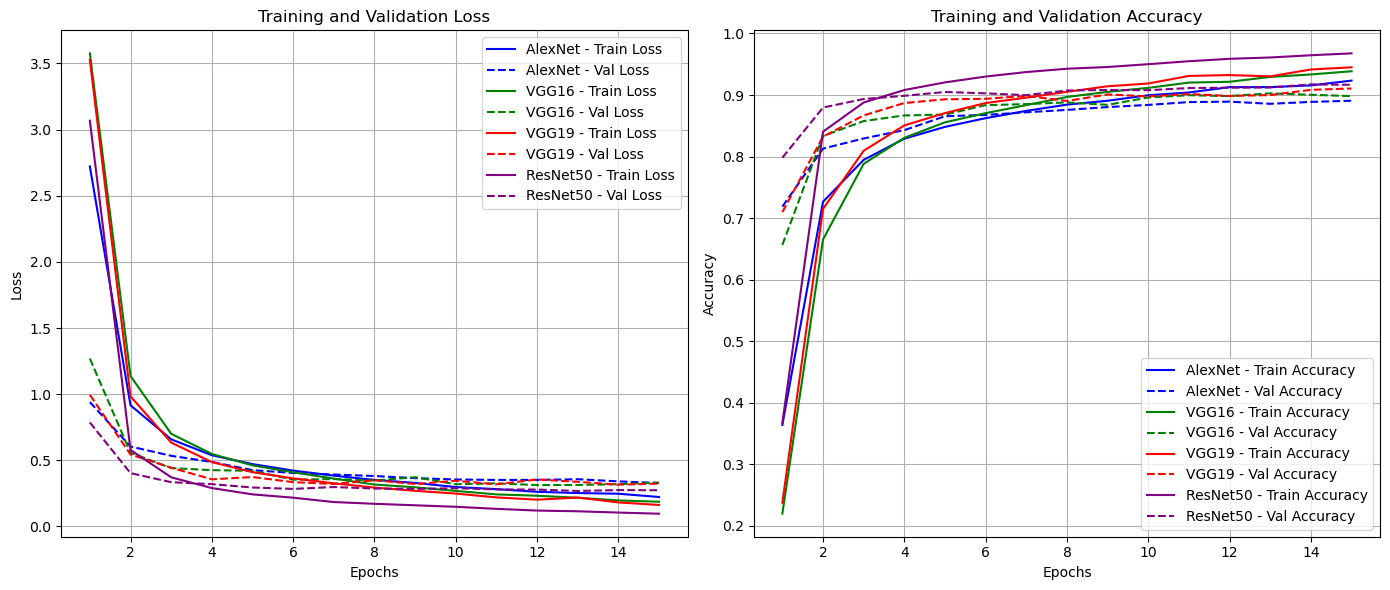

In [ ]:
import matplotlib.pyplot as plt

# Assuming 15 epochs
epochs = range(1, 16)

# Sample data for each model (replace with your actual data)
# AlexNet Data (15 epochs)
alexnet_train_loss = [2.7216, 0.9157, 0.6586, 0.5380, 0.4713, 0.4220, 0.3838, 0.3517, 0.3288, 0.2978, 0.2821, 0.2617, 0.2523, 0.2472, 0.2225]
alexnet_val_loss = [0.9398, 0.6042, 0.5337, 0.4875, 0.4255, 0.4043, 0.3925, 0.3810, 0.3649, 0.3549, 0.3514, 0.3518, 0.3569, 0.3405, 0.3285]
alexnet_train_acc = [0.3638, 0.7265, 0.7946, 0.8290, 0.8482, 0.8624, 0.8742, 0.8844, 0.8907, 0.8996, 0.9041, 0.9128, 0.9128, 0.9156, 0.9234]
alexnet_val_acc = [0.7186, 0.8129, 0.8294, 0.8429, 0.8655, 0.8676, 0.8719, 0.8758, 0.8804, 0.8839, 0.8885, 0.8892, 0.8857, 0.8888, 0.8907]

# VGG16 Data
vgg16_train_loss = [3.5763, 1.1370, 0.7005, 0.5479, 0.4615, 0.4092, 0.3616, 0.3168, 0.2957, 0.2687, 0.2421, 0.2320, 0.2169, 0.1965, 0.1867]
vgg16_val_loss = [1.2690, 0.5568, 0.4413, 0.4254, 0.4205, 0.3533, 0.3582, 0.3470, 0.3719, 0.3190, 0.3256, 0.3126, 0.3131, 0.3194, 0.3316]
vgg16_train_acc = [0.2195, 0.6653, 0.7881, 0.8304, 0.8556, 0.8705, 0.8836, 0.8968, 0.9051, 0.9116, 0.9202, 0.9215, 0.9294, 0.9334, 0.9386]
vgg16_val_acc = [0.6564, 0.8333, 0.8576, 0.8668, 0.8681, 0.8835, 0.8852, 0.8880, 0.8840, 0.8960, 0.8997, 0.8982, 0.9027, 0.9004, 0.8982]

vgg19_train_loss = [3.5268, 0.9837, 0.6340, 0.4864, 0.4102, 0.3630, 0.3261, 0.2935, 0.2692, 0.2483, 0.2194, 0.2023, 0.2182, 0.1814, 0.1624]
vgg19_val_loss = [0.9947, 0.5437, 0.4439, 0.3562, 0.3734, 0.3347, 0.3213, 0.3493, 0.3205, 0.3450, 0.3185, 0.3549, 0.3370, 0.3157, 0.3238]
vgg19_train_acc = [0.2374, 0.7149, 0.8094, 0.8506, 0.8706, 0.8870, 0.8957, 0.9052, 0.9142, 0.9187, 0.9310, 0.9324, 0.9303, 0.9415, 0.9450]
vgg19_val_acc = [0.7097, 0.8323, 0.8668, 0.8870, 0.8930, 0.8938, 0.8986, 0.8903, 0.9009, 0.8978, 0.9016, 0.8984, 0.8999, 0.9084, 0.9106]

resnet50_train_loss = [3.0670, 0.5782, 0.3715, 0.2901, 0.2424, 0.2174, 0.1844, 0.1711, 0.1598, 0.1484, 0.1330, 0.1199, 0.1146, 0.1048, 0.0962]
resnet50_val_loss = [0.7861, 0.4028, 0.3344, 0.3197, 0.2943, 0.2836, 0.2978, 0.2866, 0.2833, 0.2890, 0.2798, 0.2786, 0.2683, 0.2748, 0.2737]
resnet50_train_acc = [0.3670, 0.8404, 0.8878, 0.9081, 0.9205, 0.9300, 0.9373, 0.9427, 0.9455, 0.9501, 0.9549, 0.9588, 0.9610, 0.9646, 0.9677]
resnet50_val_acc = [0.7982, 0.8796, 0.8935, 0.8987, 0.9049, 0.9027, 0.8997, 0.9073, 0.9082, 0.9078, 0.9113, 0.9119, 0.9123, 0.9172, 0.9166]

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Loss Curves for all models
axs[0].plot(epochs, alexnet_train_loss, label='AlexNet - Train Loss', color='b')
axs[0].plot(epochs, alexnet_val_loss, label='AlexNet - Val Loss', linestyle='--', color='b')

axs[0].plot(epochs, vgg16_train_loss, label='VGG16 - Train Loss', color='g')
axs[0].plot(epochs, vgg16_val_loss, label='VGG16 - Val Loss', linestyle='--', color='g')

axs[0].plot(epochs, vgg19_train_loss, label='VGG19 - Train Loss', color='r')
axs[0].plot(epochs, vgg19_val_loss, label='VGG19 - Val Loss', linestyle='--', color='r')

axs[0].plot(epochs, resnet50_train_loss, label='ResNet50 - Train Loss', color='purple')
axs[0].plot(epochs, resnet50_val_loss, label='ResNet50 - Val Loss', linestyle='--', color='purple')

axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot Accuracy Curves for all models
axs[1].plot(epochs, alexnet_train_acc, label='AlexNet - Train Accuracy', color='b')
axs[1].plot(epochs, alexnet_val_acc, label='AlexNet - Val Accuracy', linestyle='--', color='b')

axs[1].plot(epochs, vgg16_train_acc, label='VGG16 - Train Accuracy', color='g')
axs[1].plot(epochs, vgg16_val_acc, label='VGG16 - Val Accuracy', linestyle='--', color='g')

axs[1].plot(epochs, vgg19_train_acc, label='VGG19 - Train Accuracy', color='r')
axs[1].plot(epochs, vgg19_val_acc, label='VGG19 - Val Accuracy', linestyle='--', color='r')

axs[1].plot(epochs, resnet50_train_acc, label='ResNet50 - Train Accuracy', color='purple')
axs[1].plot(epochs, resnet50_val_acc, label='ResNet50 - Val Accuracy', linestyle='--', color='purple')

axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

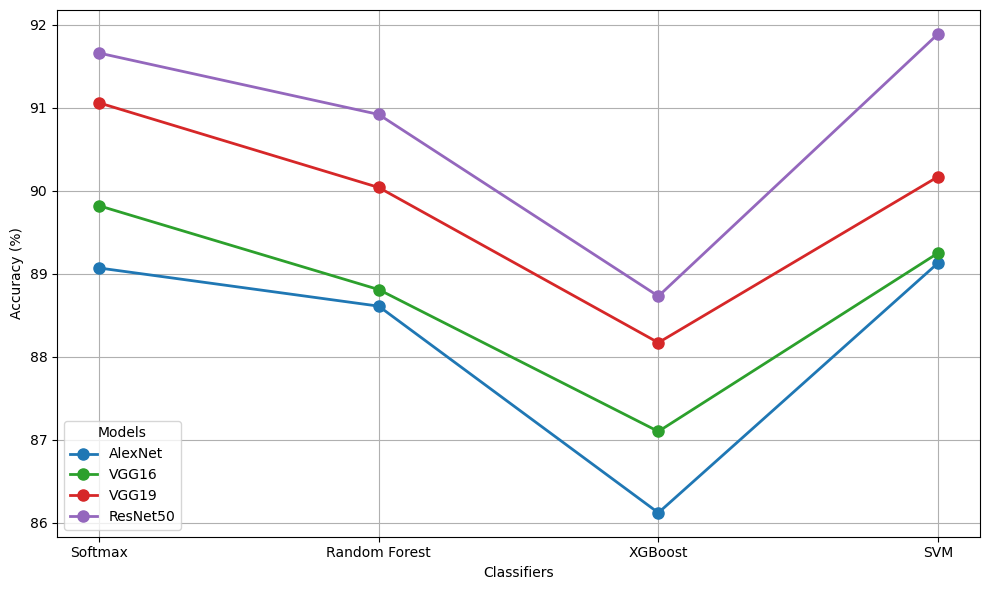

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['AlexNet', 'VGG16', 'VGG19', 'ResNet50']
classifiers = ['Softmax', 'Random Forest', 'XGBoost', 'SVM']

accuracy = [
    [89.07, 88.61, 86.12, 89.13],
    [89.82, 88.81, 87.10, 89.25],
    [91.06, 90.04, 88.17, 90.17],
    [91.66, 90.92, 88.73, 91.89]
]

x = np.arange(len(classifiers))

fig, ax = plt.subplots(figsize=(10, 6))

line_styles = ['-', '-', '-', '-']
markers = ['o', 'o', 'o', 'o']
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']

for i, model in enumerate(models):
    ax.plot(x, [accuracy[i][j] for j in range(len(classifiers))],
            label=model,
            color=colors[i],
            linestyle=line_styles[i],
            marker=markers[i],
            markersize=8,
            linewidth=2)

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend(title='Models')
ax.grid(True)

plt.tight_layout()
plt.show()